# Assignment 2: Text Classification with Convolutional Neural Networks

**Description:** This assignment covers various neural network architectures and components, largely used in the context of classification. You will compare Deep Averaging Networks, Convolutional Neural Networks, and BERT-based models. In part two, you should be able to develop an intuition for:


*   The effects of fine-tuning word vectors and over fitting the model
*   How various hyperparameters can help or hurt overfitting




The assignment notebook closely follows the lesson notebooks. We will use the IMDB dataset and will leverage some of the models, or part of the code, for our current investigation.

This notebook uses the Keras 3 functional API.  Make sure the correct versions get loaded.




## IMPORTANT NOTE:
Because of the environment built in to Colab, the software we're importing causes an error to be thrown the first time you run the cells in the Setup section.  As soon as you hit the error, you have to go to the Runtime menu and select 'Restart Session'.  Once the session is restarted you must rerun the cells in Setup and you will not run in to the error.

<a id = 'returnToTop'></a>

## Notebook Contents
  * 1. [Setup](#setup)
  * 2. [Creation of the Dataset](#creationOfDataset)  
  * 3. [Modeling](#modeling)
    * 3.1 [Fix Convolutional Neural Net (CNN) Over Fitting](#modelCNN)


  
  
  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2025-fall-main/blob/master/assignment/a2/Text_classification_CNN.ipynb)

[Return to Top](#returnToTop)  
<a id = 'setup'></a>
## 1. Setup

This notebook requires the tensorflow dataset and other prerequisites that you must download and then store locally in your Colab environment.


In [1]:
# Install uv, the fast package manager
!pip install uv --quiet
!uv pip install pydot gensim tensorflow-datasets tensorflow-text --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 108.6 MB/s eta 0:00:00


In [ ]:
# This command forces the session to restart.
# Run this cell after your installations.
# It will cause a notification "your session crashed for an unknown reason". This is OK.
import os
os.kill(os.getpid(), 9)

Ready to do the imports.

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"


import numpy as np
import tensorflow as tf
import keras

from keras.layers import Embedding, Input, Dense, Lambda
from keras.models import Model
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re


import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

Below is a helper function to plot histories.

In [2]:
# 4-window plot. Small modification from matplotlib examples.
def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    """
    Compare training histories of two models by plotting loss and accuracy.

    Parameters
    ----------
    axs : numpy.ndarray of matplotlib.axes.Axes
        2x2 grid of Axes objects (rows = metrics, cols = models).
    model_history1 : keras.callbacks.History
        Training history object for the first model.
    model_history2 : keras.callbacks.History
        Training history object for the second model.
    model_1_name : str
        Display name for the first model (default: 'model 1').
    model_2_name : str
        Display name for the second model (default: 'model 2').

    Notes
    -----
    - This function assumes `axs` is a 2D array where:
        axs[0,0] = loss for model 1, axs[0,1] = loss for model 2
        axs[1,0] = accuracy for model 1, axs[1,1] = accuracy for model 2
    - It will plot both training and validation curves for each metric.
    """

    # Create a box style for axis labels
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    # Iterate over metrics to plot: 'loss' and 'accuracy'
    for i, metric in enumerate(['loss', 'accuracy']):

        # Some models (e.g., Weighted Averaging with Attention) store metrics under different keys
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        # Calculate lower y-limit: minimum value across both models, scaled down a bit
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        # Calculate upper y-limit: maximum value across both models, scaled up a bit
        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        # Iterate over both models for this metric
        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]  # pick proper model name
            model_metric = [metric, metric2][j]           # pick proper metric key

            # Select correct subplot
            ax1 = axs[i, j]

            # Plot training history
            ax1.plot(model_history.history[model_metric], label='train')
            # Plot validation history
            ax1.plot(model_history.history['val_%s' % model_metric], label='val')

            # Title: metric + model name
            ax1.set_title('%s - %s' % (metric, model_name))

            # Label y-axis with a styled box
            ax1.set_ylabel(metric, bbox=box)

            # Keep y-limits consistent between both models for fair comparison
            ax1.set_ylim(y_lim_lower, y_lim_upper)

            # Add legend for clarity
            ax1.legend()


Next, we get the word2vec model from nltk.

In [3]:
nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

wvmodel = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


We can now build the embedding matrix and a vocabulary dictionary:

In [4]:
EMBEDDING_DIM = len(wvmodel['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map, with an extra row for unknown tokens
embedding_matrix = np.zeros((len(wvmodel) + 1, EMBEDDING_DIM))

# vacab dict will have word as key and their index in the embedding matrix as value
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(wvmodel.index_to_key):
    # The the embedding vector for the word
    embedding_vector = wvmodel[word]

    if embedding_vector is not None:
        # Construct the embedding matrix, words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

        # construct the vocab dict for index lookup
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [5]:
embedding_matrix.shape

(43982, 300)

[Return to Top](#returnToTop)  
<a id = 'creationOfDataset'></a>
## 2. Creation of the Dataset

### 2.1 Data Acquisition

We will use the IMDB dataset delivered as part of the tensorflow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [6]:
# ------------------------------------------------------------------
# 1) Load IMDB with TFDS
#    - as_supervised=True returns (text_tensor, label_tensor) pairs
#    - 'train[:80%]'  -> first 20,000 of the 25,000 train examples
#    - 'test[80%:]'   -> last 5,000 of the 25,000 test examples
# ------------------------------------------------------------------
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=("train[:80%]", "test[80%:]"),
    as_supervised=True
)

# Optional: shuffle before batching (useful if you plan to sample)
# train_data = train_data.shuffle(20000, reshuffle_each_iteration=False)
# test_data  = test_data.shuffle(5000, reshuffle_each_iteration=False)

# ------------------------------------------------------------------
# 2) Materialize the entire split into a single batch
#    - .batch(N) groups N elements into one tensor
#    - next(iter(...)) fetches that single batch
#    WARNING: This pulls everything into memory at once.
# ------------------------------------------------------------------
train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples,  test_labels  = next(iter(test_data.batch(5000)))

# ------------------------------------------------------------------
# 3) Inspect shapes/dtypes (sanity check)
# ------------------------------------------------------------------
print("train_examples:", train_examples.shape, train_examples.dtype)  # (20000,) string
print("train_labels:  ", train_labels.shape,  train_labels.dtype)     # (20000,) int64
print("test_examples: ", test_examples.shape,  test_examples.dtype)   # (5000,) string
print("test_labels:   ", test_labels.shape,   test_labels.dtype)      # (5000,) int64

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.FU9R4D_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.FU9R4D_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.FU9R4D_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
train_examples: (20000,) <dtype: 'string'>
train_labels:   (20000,) <dtype: 'int64'>
test_examples:  (5000,) <dtype: 'string'>
test_labels:    (5000,) <dtype: 'int64'>


Next, we tokenize the data:

In [7]:
# WhitespaceTokenizer() → splits text wherever it sees whitespace (' ', \n, \t).
# tokenize(train_examples) → applies this to each review in train_examples.
# Each review becomes a 1-D tensor of tokens (words, punctuation stuck to words, contractions, etc.).
# So train_tokens[0] shows the tokens for the first review in train_examples.

tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

Does this look right?

In [8]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

Yup... looks right. Of course we will need to take care of the encoding later.

### 2.2 Data Preparation

For the models we will use, we need to define a maximum sequence length (max number of tokens per movie review that we'll feed into our model). We'll cut off any tokens longer than that, and we'll pad shorter movie reviews with zeros at the end.

In [9]:
MAX_SEQUENCE_LENGTH = 128

Next, we define a simple function that converts the tokens of each movie review into their word2vec vocabulary index values.   

In [10]:
def docs_to_vocab_ids(
        tokenized_texts_list,
        vocab_dict, # passing it in to be more explicit
        MAX_SEQUENCE_LENGTH, # passing it in to be more explicit
):
    """
    Convert a collection of tokenized documents into fixed-length
    sequences of integer vocab IDs.

    Parameters
    ----------
    tokenized_texts_list : list of tf.Tensor
        Each element is a tokenized document, represented as a
        Tensor of tokens in byte-string format (dtype=string).
        Example: [b'This', b'is', b'a', b'movie', b'.'].
    vocab_dict : dict
        A dictionary mapping word strings to integer IDs. Must also
        contain a special '[UNK]' token for unknown or padding values.
    MAX_SEQUENCE_LENGTH : int
        Maximum number of tokens to keep per document. Longer documents
        are truncated, shorter documents are padded with '[UNK]' IDs.

    Returns
    -------
    np.ndarray
        2D NumPy array of shape (num_docs, MAX_SEQUENCE_LENGTH), where
        each row is the integer ID sequence corresponding to one document.
        All rows have equal length due to truncation/padding.
    """
    texts_vocab_ids = []   # list to collect all documents as ID sequences

    for i, token_list in enumerate(tokenized_texts_list):

        # ----------------------------------------------------------
        # Step 1: Convert tokens (bytes) into vocab IDs
        # ----------------------------------------------------------
        vocab_ids = []
        for token in list(token_list.numpy()):
            # token is a byte string -> decode into Python string
            decoded = token.decode('utf-8', errors='ignore')

            # Use vocab ID if word is known, else map to [UNK]
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # ----------------------------------------------------------
        # Step 2: Enforce fixed length
        # ----------------------------------------------------------
        # Truncate if sequence is longer than MAX_SEQUENCE_LENGTH
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]

        # Pad with [UNK] IDs if sequence is too short
        n_padding = MAX_SEQUENCE_LENGTH - len(vocab_ids)
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # ----------------------------------------------------------
        # Step 3: Append processed doc to results
        # ----------------------------------------------------------
        texts_vocab_ids.append(vocab_ids)

        # Print progress every 5000 docs processed
        if i % 5000 == 0:
            print('Examples processed:', i)

    print('Total examples:', i+1)

    # --------------------------------------------------------------
    # Step 4: Convert list of lists into a NumPy array for modeling
    # --------------------------------------------------------------
    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.

In [11]:
# Convert tokenized datasets into integer ID sequences
train_input_ids = docs_to_vocab_ids(train_tokens, vocab_dict, MAX_SEQUENCE_LENGTH)
test_input_ids  = docs_to_vocab_ids(test_tokens,  vocab_dict, MAX_SEQUENCE_LENGTH)

# Convert labels from tensors to NumPy arrays for modeling
train_input_labels = np.array(train_labels)
test_input_labels  = np.array(test_labels)

Examples processed: 0
Examples processed: 5000
Examples processed: 10000
Examples processed: 15000
Total examples: 20000
Examples processed: 0
Total examples: 5000


Let's convince ourselves that the data looks correct.  We expect the train data to be an array of integer ids and the labels to be an array of zeroes and ones (since we are learning a binary classifier).

In [12]:
train_input_ids[:2]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958,  5589,  8092, 43981, 34516, 43981,  8092, 16182, 43981,
        39933, 43981, 12139,  2326, 32781, 32467,  7046, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [13]:
train_input_labels[:4]

array([0, 0, 0, 1])

[Return to Top](#returnToTop)  
<a id = 'modeling'></a>
## 3. Modeling




<a id = 'modelCNN'></a>
### 3.1 CNN Model

Next let's build a CNN model. We'll also wrap the model building code in a function that takes some hyperparameters, so that we can adjust things like number of filters and filter sizes later.

In [14]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    """
    Build a CNN-based text classification model.

    Parameters
    ----------
    num_filters : list of int
        Number of convolution filters for each kernel size.
        Example: [100, 100, 100].
    kernel_sizes : list of int
        Filter (window) sizes for the convolutions.
        Example: [3, 4, 5] → tri-grams, 4-grams, 5-grams.
    dense_layer_dims : list of int
        Sizes of fully connected dense layers after convolution.
    dropout_rate : float
        Dropout rate applied after concatenating convolution outputs.
    embeddings_trainable : bool, optional (default=False)
        Whether pretrained embeddings should be fine-tuned.

    Returns
    -------
    cnn_model : keras.Model
        A compiled Keras model ready for training.
    """

    # ------------------------------------------------------------
    # Step 1: Input & Embedding
    # ------------------------------------------------------------
    # Input: sequences of integer vocab IDs
    cnn_input_layer = keras.layers.Input(
        shape=(MAX_SEQUENCE_LENGTH,), dtype='int64'
    )

    # Embedding layer: maps vocab IDs → pretrained word vectors
    cnn_embedding_layer = Embedding(
        input_dim=embedding_matrix.shape[0],    # vocab size
        output_dim=embedding_matrix.shape[1],   # embedding dimension
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=embeddings_trainable
    )
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)
    # Shape: (batch_size, MAX_SEQUENCE_LENGTH, embedding_dim)

    # ------------------------------------------------------------
    # Step 2: Convolution + Global Max Pooling
    # ------------------------------------------------------------
    # Apply multiple Conv1D filters with different kernel sizes
    # to capture n-gram features (e.g., tri-grams, 4-grams, etc.).
    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        # Convolution layer
        conv_layer = keras.layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='relu'
        )(cnn_embeddings)
        # Shape: (batch_size, MAX_SEQUENCE_LENGTH - kernel_size + 1, filters)

        # Global max pooling → pick strongest signal across sequence
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        # Shape: (batch_size, filters)

        # Collect this conv output
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    # Concatenate outputs from all conv layers
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    # Shape: (batch_size, sum(num_filters))

    # ------------------------------------------------------------
    # Step 3: Dropout regularization
    # ------------------------------------------------------------
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    # ------------------------------------------------------------
    # Step 4: Dense hidden layers
    # ------------------------------------------------------------
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(
            dense_layer_dim, activation='relu'
        )(last_hidden_output)

    # ------------------------------------------------------------
    # Step 5: Output layer
    # ------------------------------------------------------------
    # Single sigmoid neuron for binary classification
    cnn_prediction = keras.layers.Dense(
        1, activation='sigmoid'
    )(last_hidden_output)

    # ------------------------------------------------------------
    # Step 6: Build & compile model
    # ------------------------------------------------------------
    cnn_model = keras.Model(
        inputs=cnn_input_layer,
        outputs=cnn_prediction
    )

    cnn_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',   # common for binary classification
        metrics=['accuracy']
    )

    return cnn_model


In [15]:
# ------------------------------------------------------------
# Step 1: Define CNN hyperparameters
# ------------------------------------------------------------

# Number of filters (output channels) for each convolution layer.
# Matches one-to-one with kernel_sizes below.
# Example: for kernel_size=3 → 100 filters, etc.
num_filters = [100, 100, 50, 25]

# Convolution kernel sizes (window widths over the sequence).
#   3 → tri-grams
#   4 → 4-grams
#   5 → 5-grams
#   10 → longer patterns spanning 10 tokens
kernel_sizes = [3, 4, 5, 10]

# Sizes of fully connected dense layers after convolution outputs
#   First dense layer → 100 units
#   Second dense layer → 50 units
dense_layer_dims = [100, 50]

# Dropout rate (fraction of units randomly dropped during training)
# Applied after concatenating convolution outputs → helps prevent overfitting
dropout_rate = 0.5

# ------------------------------------------------------------
# Step 2: Build the CNN model
# ------------------------------------------------------------
# Calls the build_cnn_model function we defined earlier.
# - Uses the hyperparameters specified above.
# - By default, embeddings_trainable=False, so pretrained embeddings are frozen.
cnn_model = build_cnn_model(
    num_filters=num_filters,
    kernel_sizes=kernel_sizes,
    dense_layer_dims=dense_layer_dims,
    dropout_rate=dropout_rate
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 300)  │ 13,194,600 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 126, 100)  │     90,100 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 125, 100)  │    120,100 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 124, 50)   │     75,050 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 119, 25)   │     75,025 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 50)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 25)        │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 275)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 275)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100)       │     27,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50)        │      5,050 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         51 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,587,576 (51.83 MB)

 Trainable params: 392,976 (1.50 MB)

 Non-trainable params: 13,194,600 (50.33 MB)

The keras plot utility shows this probably a bit nicer:

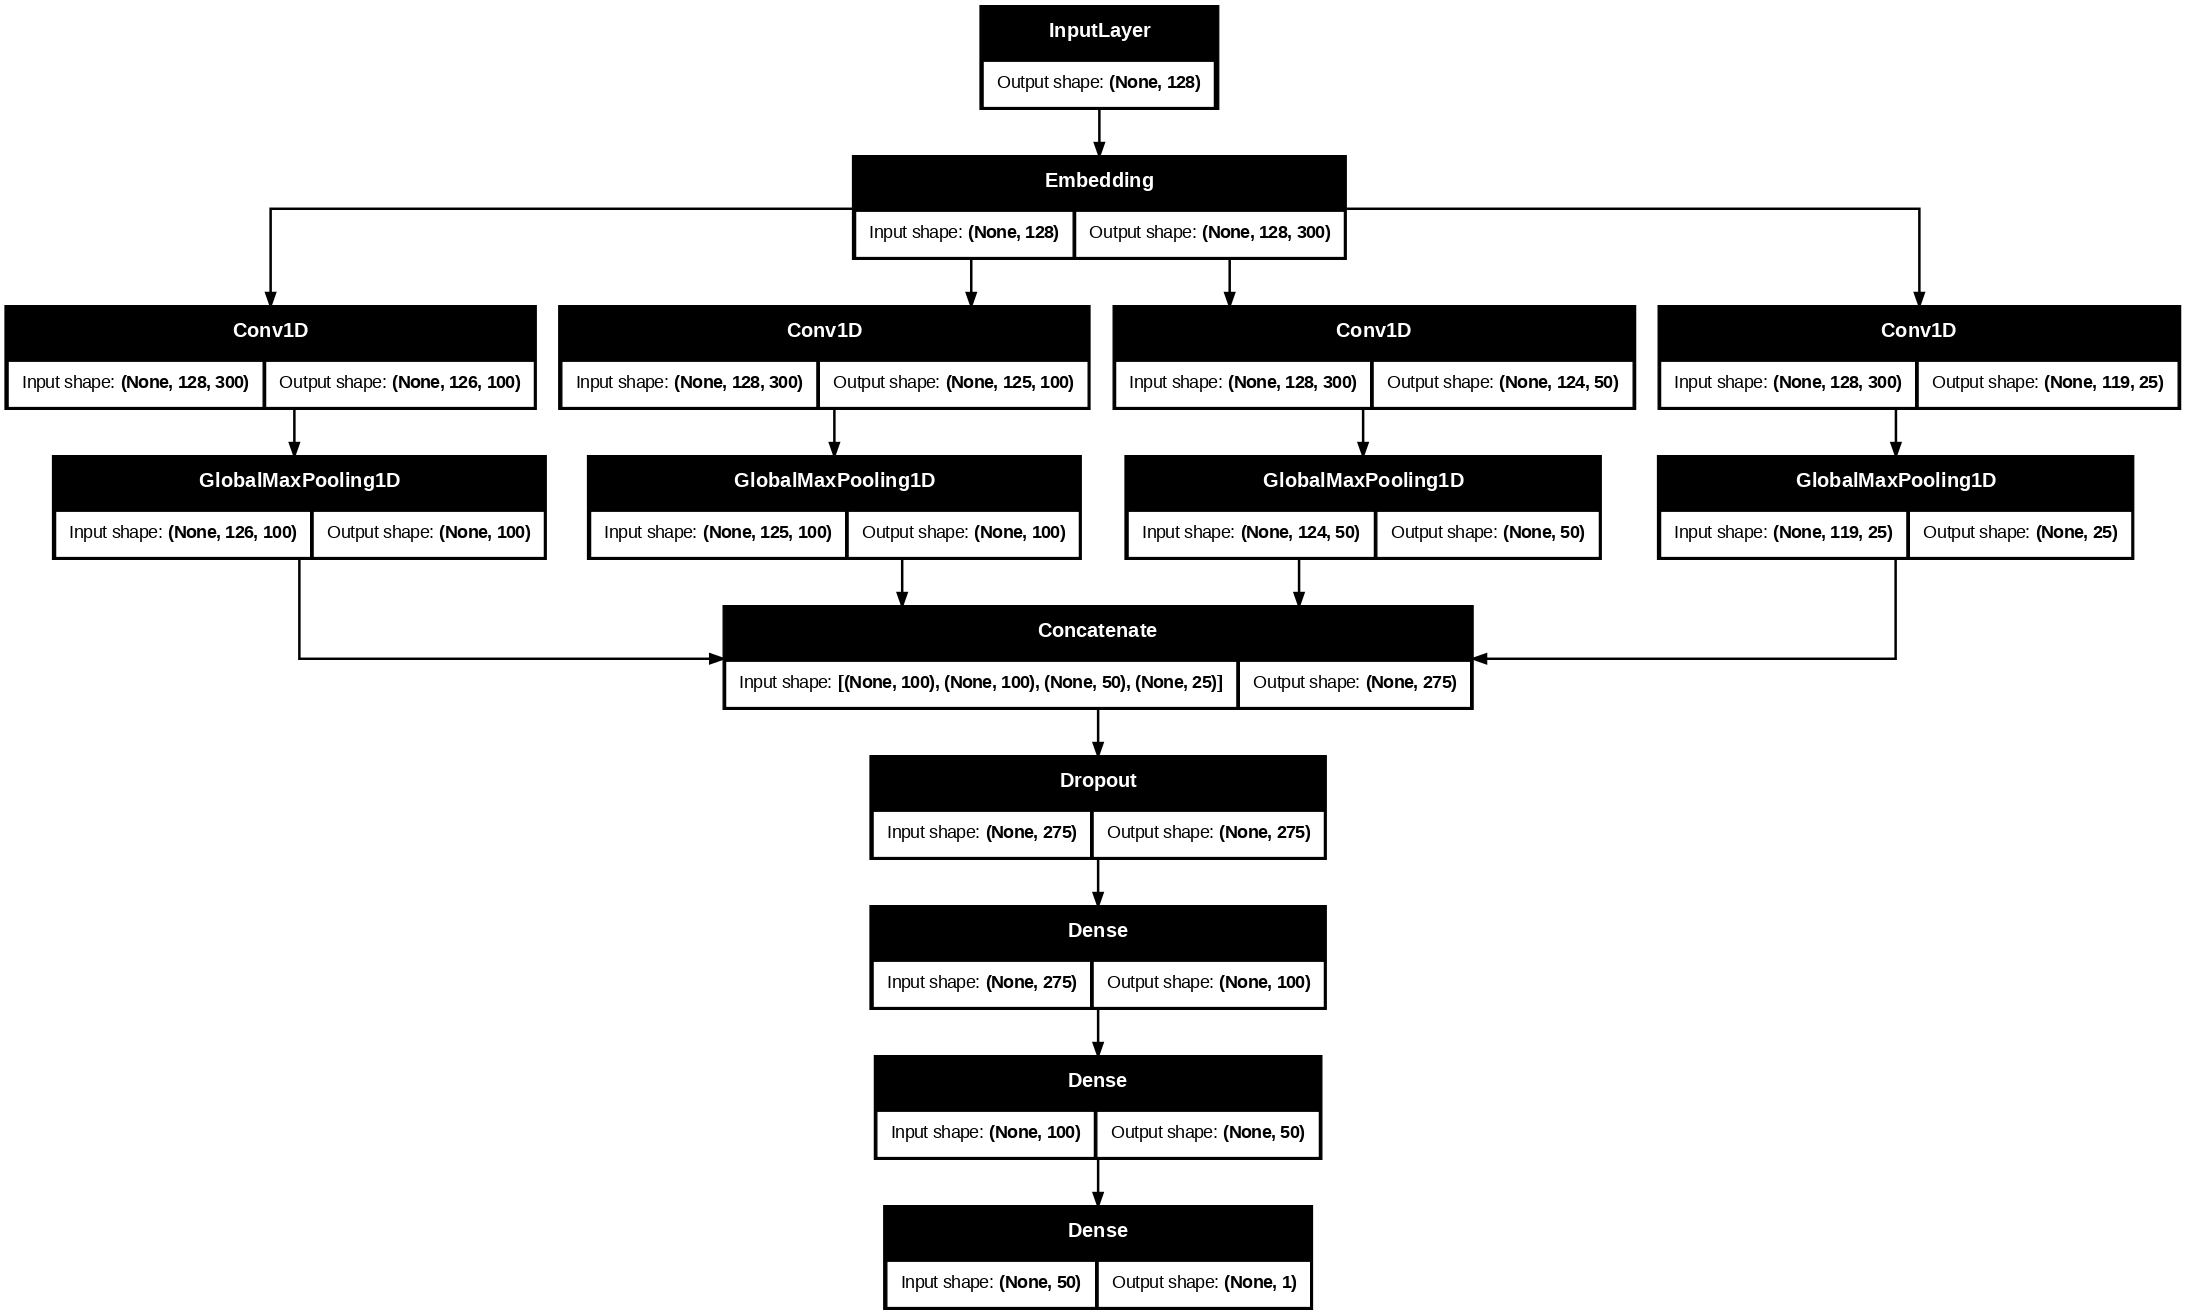

In [17]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

Now let's train our CNN and see if it can learn without overfitting or underfitting.

In [18]:
cnn_history = cnn_model.fit(train_input_ids,
                            train_input_labels,
                            validation_data=(test_input_ids, test_input_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.6308 - loss: 0.6168 - val_accuracy: 0.8140 - val_loss: 0.4245
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8062 - loss: 0.4193 - val_accuracy: 0.8086 - val_loss: 0.4170
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8363 - loss: 0.3690 - val_accuracy: 0.8178 - val_loss: 0.4018
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8629 - loss: 0.3202 - val_accuracy: 0.8224 - val_loss: 0.3985
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8925 - loss: 0.2661 - val_accuracy: 0.8198 - val_loss: 0.4068


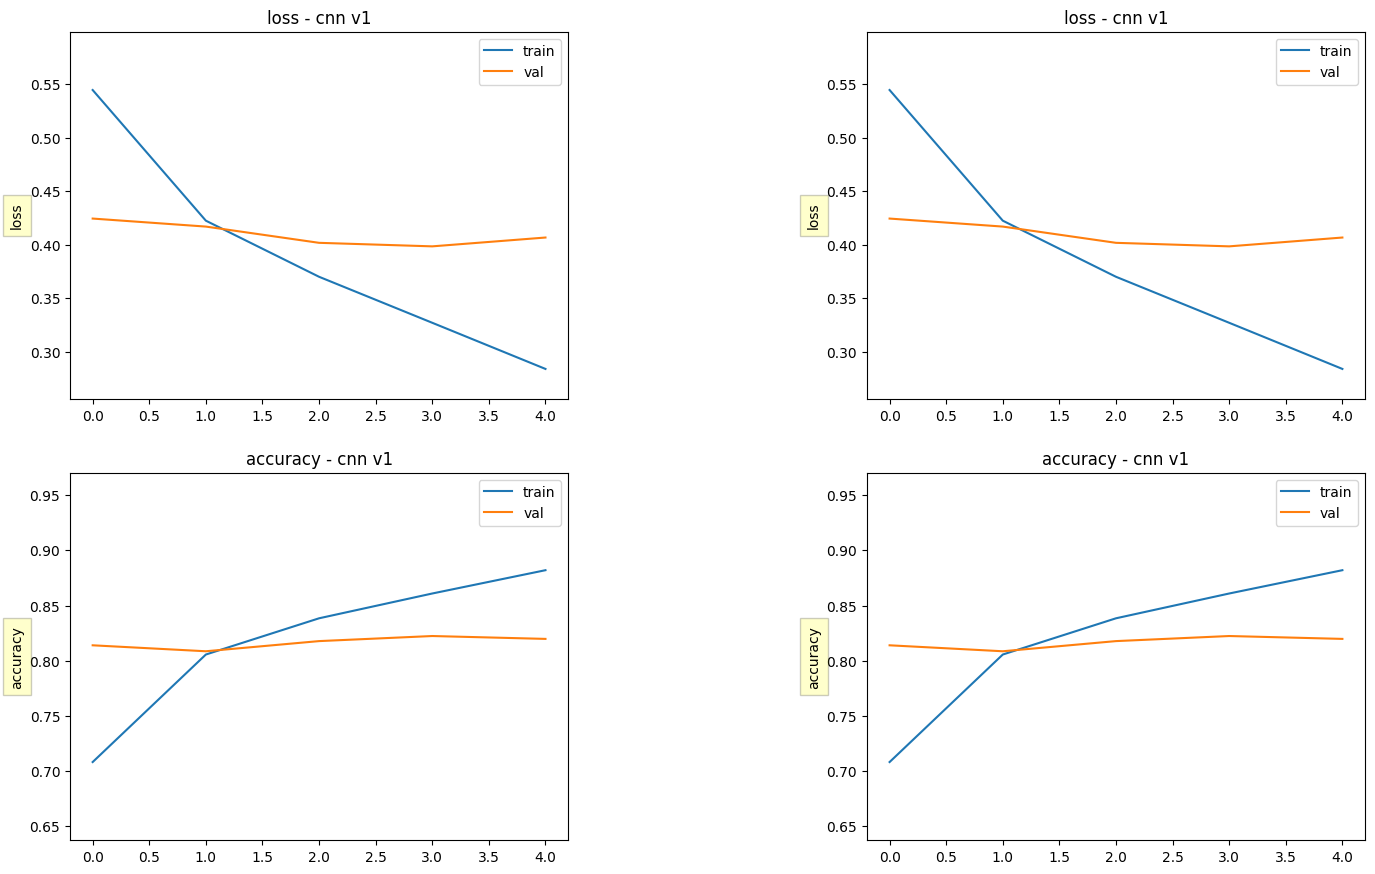

In [19]:
# Do the plots change how you'd expect?
# Did the runtime change (in the cells above)?

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history,
          cnn_history,
          model_1_name='cnn v1',
          model_2_name='cnn v1')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

[Return to Top](#returnToTop)  
<a id = 'cnnExercise'></a>
### 3.2. CNN Exercise

A. The CNN model above is overfitting.  You can tell this because the training loss keeps going down while the validation loss is increasing. Can you make the CNN model overfit less? What parameter(s) might you change to make this model less likely to overfit? How good (or bad) can you make it get?

> Hint: think about all of the options you can vary, including:
* add/remove more hidden layers
* vary dropout rates and dimensions
* enable/disable retraining of embedding matrix
* change number of filters
* change kernel sizes of filters
* change the batch size
>
> For the option(s) you choose, do you think it will make the model more or less likely to overfit? Try it, does it work the way you expect?

Here is an example of the loss curve for a model that is extremely overfit:

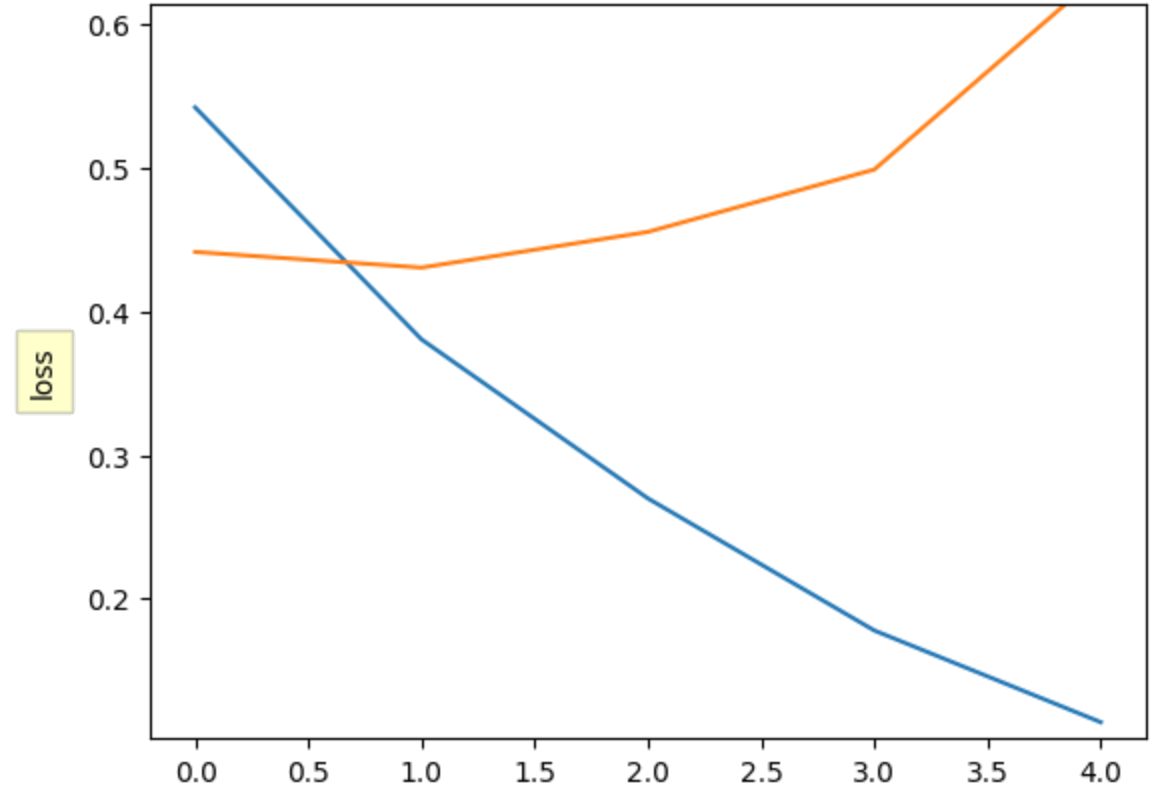

and here is an example of the loss curve where the model is converging and not overfitting:

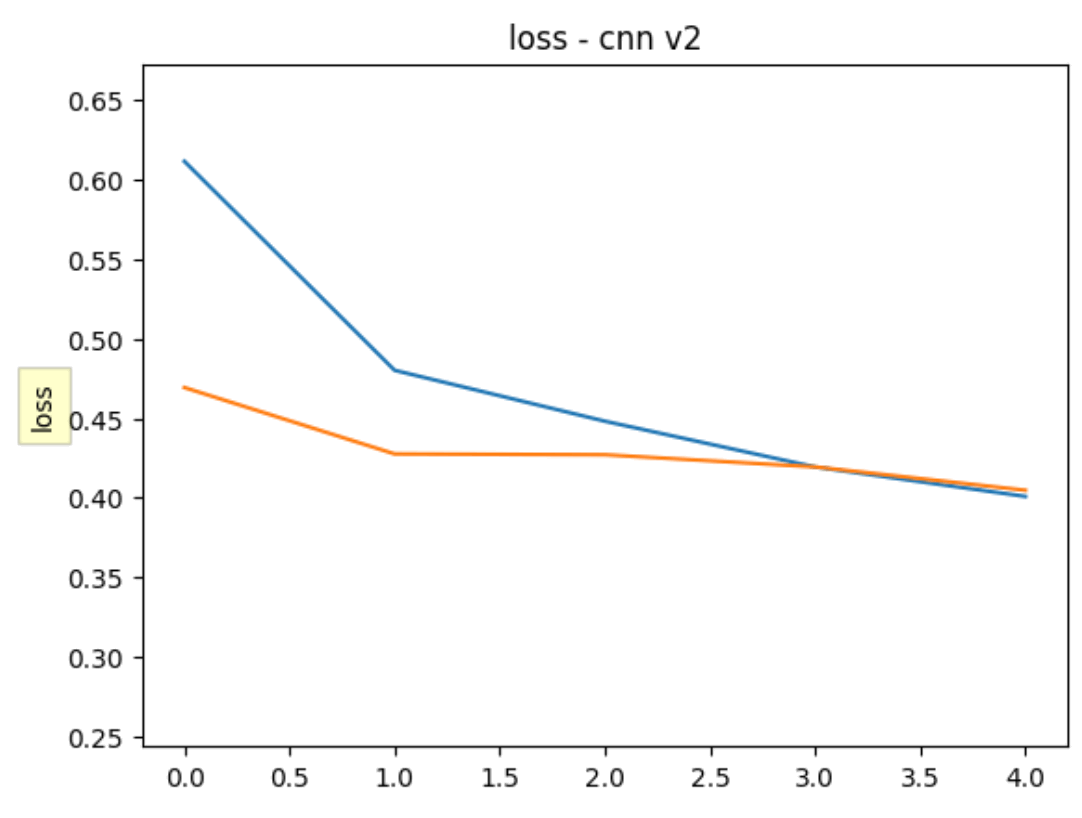


Your task is to fix the CNN model so that it is no longer overfit when you train it.  You should modify the specified hyperparameters until the model no longer overfits. We define your goal as a case where after each epoch, the loss and val_loss value is lower than the epoch before.  This will be reflected in the shape of the loss curves as shown above.  

In [23]:
# CNN model hyperparameters: Change these

# --- Version 2: regularized & lighter ---
num_filters2 = [64, 64, 32]         # down from [100, 100, 50, 25]
kernel_sizes2 = [3, 4, 5]           # drop the very long 10-gram branch
dense_layer_dims2 = [64]        # simpler head (was [100, 50])
dropout_rate2 = 0.6                 # up from 0.5
embeddings_trainable2 = False       # keep frozen to reduce overfit
batch_size2 = 64                    # modest bump from 32

cnn_model2 = build_cnn_model(
    num_filters=num_filters2,
    kernel_sizes=kernel_sizes2,
    dense_layer_dims=dense_layer_dims2,
    dropout_rate=dropout_rate2,
    embeddings_trainable=embeddings_trainable2
)

cnn_history2 = cnn_model2.fit(
    train_input_ids, train_input_labels,
    validation_data=(test_input_ids, test_input_labels),
    batch_size=batch_size2,
    epochs=5,
    verbose=1
)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5777 - loss: 0.6629 - val_accuracy: 0.7762 - val_loss: 0.4663
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7770 - loss: 0.4729 - val_accuracy: 0.8094 - val_loss: 0.4240
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8062 - loss: 0.4191 - val_accuracy: 0.8144 - val_loss: 0.4115
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8226 - loss: 0.3933 - val_accuracy: 0.8148 - val_loss: 0.4023
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8404 - loss: 0.3632 - val_accuracy: 0.8204 - val_loss: 0.4007


In [24]:
print("CNN v2 Training History:")
for epoch in range(len(cnn_history2.history['loss'])):
    print(f"Epoch {epoch+1}:")
    print(f"  Loss: {cnn_history2.history['loss'][epoch]:.5f}, Accuracy: {cnn_history2.history['accuracy'][epoch]:.5f}")
    print(f"  Val Loss: {cnn_history2.history['val_loss'][epoch]:.5f}, Val Accuracy: {cnn_history2.history['val_accuracy'][epoch]:.5f}")

CNN v2 Training History:
Epoch 1:
  Loss: 0.60441, Accuracy: 0.65220
  Val Loss: 0.46626, Val Accuracy: 0.77620
Epoch 2:
  Loss: 0.46524, Accuracy: 0.77960
  Val Loss: 0.42402, Val Accuracy: 0.80940
Epoch 3:
  Loss: 0.42200, Accuracy: 0.80840
  Val Loss: 0.41153, Val Accuracy: 0.81440
Epoch 4:
  Loss: 0.38986, Accuracy: 0.82510
  Val Loss: 0.40233, Val Accuracy: 0.81480
Epoch 5:
  Loss: 0.36280, Accuracy: 0.84165
  Val Loss: 0.40067, Val Accuracy: 0.82040


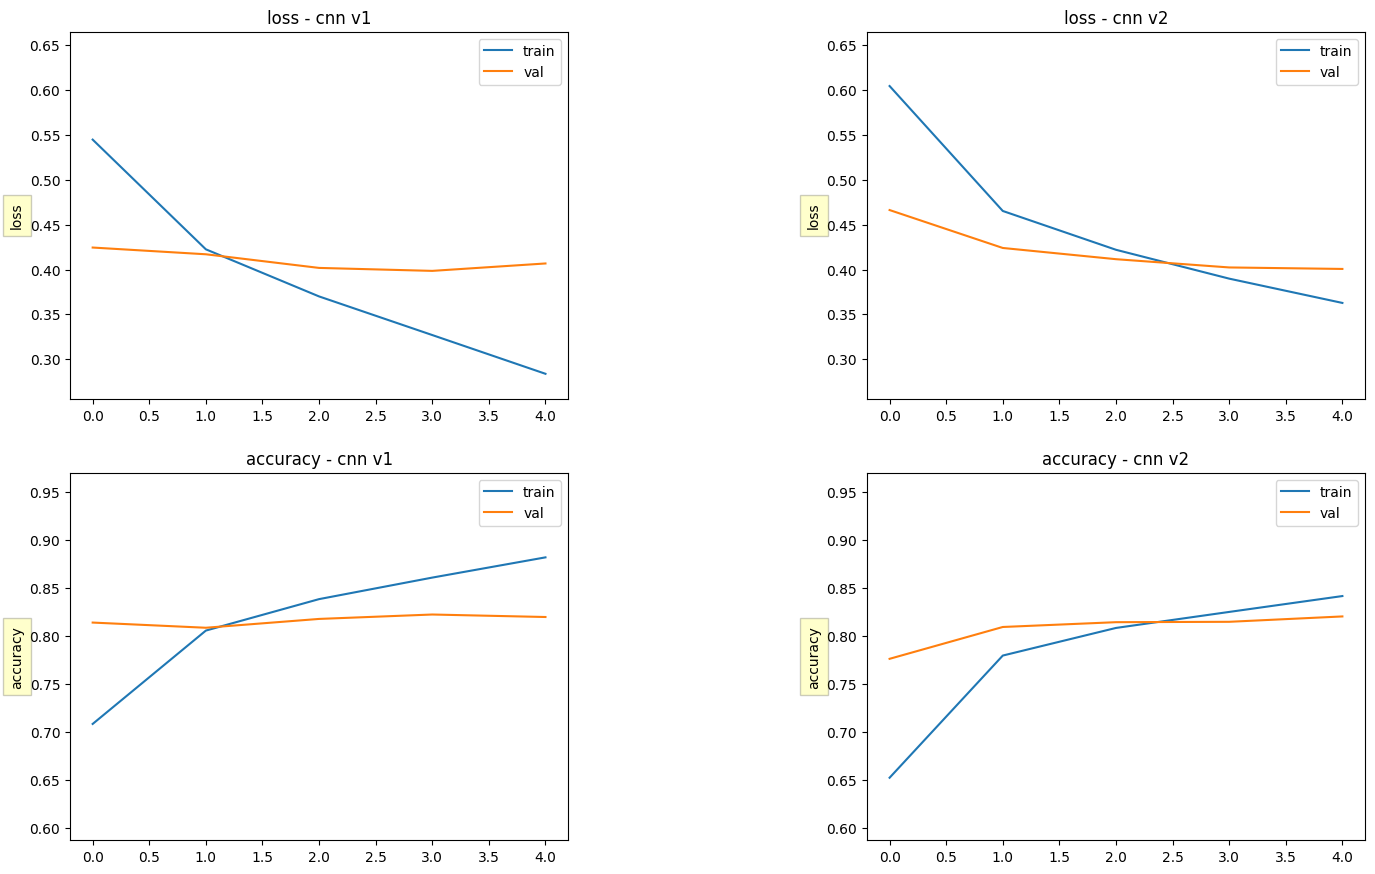

In [25]:
# Do the plots change how you'd expect?
# Did the runtime change (in the cells above)?

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history,
          cnn_history2,
          model_1_name='cnn v1',
          model_2_name='cnn v2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

 **QUESTION:**

1.a
What is the val_loss value you have after the 1st epoch of training?  Copy the value in the output to the answers file.

 **QUESTION:**

1.b
What is the val_loss value you have after the 2nd epoch of training?  Copy the value in the output to the answers file.

 **QUESTION:**

1.c
What is the val_loss value you have after the 3rd epoch of training?  Copy the value in the output to the answers file.


 **QUESTION:**

1.d
What is the val_loss value you have after the 4th epoch of training?  Copy the value in the output to the answers file.

 **QUESTION:**

1.e
What is the val_loss value you have after the 5th and final epoch of training.  Copy the value in the output to the answers file.


 **QUESTION:**

1.f
What values did you use for num_filters = [] to stop the overfitting? Copy the values into the answers file.


 **QUESTION:**

1.g
What values did you use for kernel_sizes = [] to stop the overfitting? Copy the values into the answers file.


 **QUESTION:**

1.h
What values did you use for dense__layer_dims= [] to stop the overfitting? Copy the values into the answers file.


 **QUESTION:**

1.i
What value did you use for dropout_rate = [] to stop the overfitting? Copy the value into the answers file.


 **QUESTION:**

1.j
What value did you use for embeddings_trainable = to stop the overfitting? Copy the value into the answers file.


 **QUESTION:**

1.k
What value did you use for batch_size = to stop the overfitting? Copy the value into the answers file.

You're done with this portion.  Continue on to the next notebook.